In [16]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt
from tqdm import tqdm

import rebound

from jorbit.utils.states import SystemState
from jorbit.integrators.ias15 import ias15_evolve, initialize_ias15_integrator_state
from jorbit.accelerations.newtonian import newtonian_gravity

In [24]:
init_state = SystemState(
    tracer_positions=jnp.array([[1.0, 0, 0]]),
    tracer_velocities=jnp.array([[0, 1.0, 0]]),
    massive_positions=jnp.array([[0.0, 0, 0]]),
    massive_velocities=jnp.array([[0.0, 0, 0]]),
    log_gms=jnp.array([0.0]),
    time=0.0,
    acceleration_func_kwargs={},
)

acc_func = jax.tree_util.Partial(newtonian_gravity)
a0 = acc_func(init_state)
init_integrator_state = initialize_ias15_integrator_state(a0)

num_orbits = jnp.array(list(set([int(i) for i in jnp.logspace(0, 3, 100)])))
outbound_times = jnp.array(jnp.sort(num_orbits)) * 2 * jnp.pi
final_errors_jorbit = []
final_errors_rebound = []
max_time = 100 * 2 * jnp.pi

for outbound_time in tqdm(outbound_times):

    if outbound_time < max_time:
        outbound_time = jnp.array([outbound_time])
    else:
        step_size = min(49.0, max(1.0, outbound_time / 10))
        num_steps = int(jnp.ceil(outbound_time / step_size))
        outbound_time = jnp.linspace(0, outbound_time, num_steps + 1)

    outbound_position, outbound_velocity, outbout_system_state, outbound_integrator_state = ias15_evolve(
        initial_system_state=init_state,
        acceleration_func=acc_func,
        times=outbound_time,
        initial_integrator_state=init_integrator_state,
    )

    final_position, final_velocity, final_system_state, final_integrator_state = ias15_evolve(
        initial_system_state=outbout_system_state,
        acceleration_func=acc_func,
        times=outbound_time[::-1],
        initial_integrator_state=outbound_integrator_state,
    )

    final_errors_jorbit.append(jnp.linalg.norm(final_position[0,1] - init_state.tracer_positions[0]))


    sim = rebound.Simulation()
    sim.add(m=1)
    sim.add(m=0, x=1.0, vy=1.0)
    sim.integrate(outbound_time[-1])
    sim.integrate(0)
    pos = jnp.array(sim.particles[1].xyz)
    final_errors_rebound.append(jnp.linalg.norm(pos - jnp.array([1.0,0,0])))

final_errors_jorbit = jnp.array(final_errors_jorbit)
final_errors_rebound = jnp.array(final_errors_rebound)

100%|██████████| 75/75 [00:42<00:00,  1.76it/s]


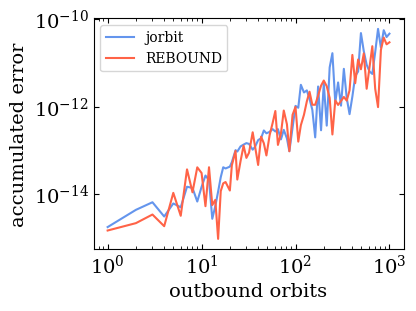

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(outbound_times / (2*jnp.pi), final_errors_jorbit / 2, label="jorbit", color="cornflowerblue")
ax.plot(outbound_times / (2*jnp.pi), final_errors_rebound / 2, label="REBOUND", color="tomato")
ax.set(xlabel="outbound orbits", ylabel="accumulated error", xscale="log", yscale="log")
ax.legend(fontsize=10)
plt.savefig("figures/outbound_error.pdf", bbox_inches="tight")